In [19]:
import requests
import json
from bs4 import BeautifulSoup 
import random
import numpy as np
from IPython.core.display import HTML
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import locale
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

HTML in Notebooks

In [20]:
%%html
<style>
    #body { background-color: #000000; }
    .sectionHeader {background-color: black; color: white; padding: 10px; font: 24px Arial;}
    .sectionBody {background-color: white; color: black; padding: 10px; font: 14px Arial;}
</style>

In [21]:
# Implementing CSS using HTML function
# css = """
# <style>
#     #body { background-color: #000000; }
#     .sectionHeader {background-color: black; color: white; padding: 10px; font: 24px Arial;}
#     .sectionBody {background-color: white; color: black; padding: 10px; font: 14px Arial;}
# </style>
# """

# #The CSS string is then included as an argument to the HTML() method of the display library
# HTML(css)

Integrating HTML and CSS into a Markdown Cell of a Notebook

Notice that the CSS in the “p” tag is embedded through inline styling using the style property. Although the <button> tag below references a CSS class, the CSS rules for the submitButton class cannot be added to the markdown cell. Instead, the submitButton class rule would be written in an earlier code cell using the methods of adding a style sheet to a notebook mentioned previously. The class would be applied to the button when the cell with the code below is run.

<header>Markdown Cell Header</header>
<section>
<p style="color: #222222; margin: 0px 0px 10px 0px;">Content of the cell.</p>
<button class="submitButton">Submit</button>
</section>
    
<form action="DataProcessing.py" method="post">
    <fieldset> 
        <legend>Profile Information</legend>
        <label for="firstName">Cell Phone:</label> 
        <input type="text" id="firstName" name="firstName"><br>
        <label for="lastName">Cell Phone:</label> 
        <input type="text" id="lastName" name="lastName"><br>
        <label for="phone">Cell Phone:</label> 
        <input type="tel" id="phone" name="phone" pattern="\([0-9]{3}\) [0-9]{3}-[0-9]{4}">
    </fieldset>
</form>



<form action="process.py" method="post"> 
    <fieldset> 
        <legend>Company Information</legend>
        <label for="companyName">Company Name:</label><br>
        <input type="text" id="companyName" name="companyName"><br>
        <label for="type">Company Type:</label><br>
        <select id="type" name="type">
            <option value="for-profit">For Profit</option>
            <option value="non-profit">Non-Profit</option>
            <option value="ngo">Non-Governmental Organization</option>
        </select><br>
        <label for="details">Company Details:</label><br>
        <textarea id="details" name="details" cols="50" name="15"></textarea>
    </fieldset>
    <fieldset> 
        <legend>Company Rep Information</legend>
        <label for="firstName">First Name:</label><br>
        <input type="text" id="firstName" name="firstName"><br>
        <label for="lastName">Last Name:</label><br>
        <input type="text" id="lastName" name="lastName"><br>
        <label for="phone">Cell Phone:</label><br> 
        <input type="tel" id="phone" name="phone" pattern="\([0-9]{3}\) [0-9]{3}-[0-9]{4}"><br>
        <label for="email">Email:</label><br> 
        <input type="email" id="email" name="email">
    </fieldset>
    <input type="submit" value="Submit">
</form>


In [22]:
CIKNumber = '0001341439'
filingType = "10-K"
baseURL = "https://www.sec.gov"

filingParameters = {'action':'getcompany',
                                  'CIK':CIKNumber,
                                  'type':filingType,
                                  'dateb':'',
                                  'owner':'exclude',
                                  'start':'',
                                  'output':'',
                                  'count':'100'}

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36'}

apiResponse = requests.get(f"https://data.sec.gov/api/xbrl/companyfacts/CIK{CIKNumber}.json", headers=header)

if apiResponse.ok:
    apiData = json.loads(apiResponse.content)
else:
    print(apiResponse.status_code)
    print(apiResponse.reason)
    
# request the url, and then parse the response.
companyResponse = requests.get(url=r"https://www.sec.gov/cgi-bin/browse-edgar", params=filingParameters, headers=header)

#print(response.content)
companyParser = BeautifulSoup(companyResponse.content, 'html.parser')
documentLink = companyParser.find("a", {"id":"documentsbutton"})
print(baseURL + documentLink["href"])

documentResponse = requests.get(baseURL + documentLink["href"], headers=header)
#print(documentResponse.content)

documentParser = BeautifulSoup(documentResponse.content, 'html.parser')
xmlTable = documentParser.find("table", {"summary":"Data Files"})
xmlTableData = xmlTable.find_all("td", {"scope":"row"})

xmlSchemaData = None

i=0

while i < len(xmlTableData):
    if xmlTableData[i].getText() == "XBRL TAXONOMY EXTENSION CALCULATION LINKBASE DOCUMENT":
        xmlSchemaData = xmlTableData[i+1].find("a")
        break
    
    i+=1
    
print(baseURL + xmlSchemaData["href"])

schemaReportResponse = requests.get(baseURL + xmlSchemaData["href"], headers=header)
#print(schemaReportResponse.content)

schemaReportParser = BeautifulSoup(schemaReportResponse.content, features="xml")
financialStatements = schemaReportParser.find_all("link:calculationLink", {"xlink:type":"extended"})

data = {"statement": []}

for statement in financialStatements:
    statementName = statement["xlink:role"].split("role/")[1]
    
    try:
        statementName = statementName.split("Role_")[1]
    except:
        continue

    statementDictionary = {"name":statementName, "concept": []}
    
    
    concepts = statement.find_all("link:calculationArc", {"xlink:type":"arc"})
    
    for concept in concepts:
        try:
            conceptDictionary = {"section":concept["xlink:from"].split("us-gaap_")[1], "name":concept["xlink:to"].split("us-gaap_")[1], "data": apiData["facts"]["us-gaap"][concept["xlink:to"].split("us-gaap_")[1]]}
        except:
            try:
                conceptDictionary = {"section":concept["xlink:from"], "name":concept["xlink:to"], "data":apiData["facts"]["us-gaap"][concept["xlink:to"].split("us-gaap_")[1]]}
            except:
                continue
        finally:
            statementDictionary["concept"].append(conceptDictionary)
    
    data["statement"].append(statementDictionary)

print(data)

https://www.sec.gov/Archives/edgar/data/1341439/000095017023028914/0000950170-23-028914-index.htm
https://www.sec.gov/Archives/edgar/data/1341439/000095017023028914/orcl-20230531_cal.xml
{'statement': [{'name': 'StatementCONSOLIDATEDBALANCESHEETS', 'concept': [{'section': 'LiabilitiesAndStockholdersEquity', 'name': 'StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest', 'data': {'label': "Stockholders' Equity, Including Portion Attributable to Noncontrolling Interest", 'description': "Amount of stockholders' equity (deficit), net of receivables from officers, directors, owners, and affiliates of the entity, attributable to both the parent and noncontrolling interests. Amount excludes temporary equity. Alternate caption for the concept is permanent equity.", 'units': {'USD': [{'end': '2007-05-31', 'val': 17235000000, 'accn': '0001193125-10-151896', 'fy': 2010, 'fp': 'FY', 'form': '10-K', 'filed': '2010-07-01', 'frame': 'CY2007Q2I'}, {'end': '2008-05-31', 'val': 2339400

In [23]:
for fs in data["statement"]:
    print(fs["name"])
    print(f'Count of Concepts: {len(fs["concept"])}')

StatementCONSOLIDATEDBALANCESHEETS
Count of Concepts: 30
StatementCONSOLIDATEDSTATEMENTSOFOPERATIONS
Count of Concepts: 20
StatementCONSOLIDATEDSTATEMENTSOFCOMPREHENSIVEINCOME
Count of Concepts: 5
StatementCONSOLIDATEDSTATEMENTSOFCASHFLOWS
Count of Concepts: 27
DisclosureORGANIZATIONANDSIGNIFICANTACCOUNTINGPOLICIESDetails
Count of Concepts: 6
DisclosureCASHCASHEQUIVALENTSANDMARKETABLESECURITIESDetails
Count of Concepts: 3
DisclosureCASHCASHEQUIVALENTSANDMARKETABLESECURITIESDetails2
Count of Concepts: 2
DisclosureFAIRVALUEMEASUREMENTSDetails
Count of Concepts: 2
DisclosurePROPERTYPLANTANDEQUIPMENTDetails
Count of Concepts: 7
DisclosureINTANGIBLEASSETSDetails
Count of Concepts: 2
DisclosureINTANGIBLEASSETSAMORTIZATIONDetails
Count of Concepts: 6
DisclosureNOTESPAYABLEANDOTHERBORROWINGSDetails
Count of Concepts: 3
DisclosureFUTUREPRINCIPALPAYMENTSFORALLBORROWINGSDetails
Count of Concepts: 6
DisclosureNOTESPAYABLEANDOTHERBORROWINGSDetails2
Count of Concepts: 2
DisclosureDEFERREDREVENUESDet

In [24]:
financialStatementIndex = 1
print(data["statement"][financialStatementIndex]["name"])
print(f'Count of Concepts: {len(data["statement"][financialStatementIndex]["concept"])}')

StatementCONSOLIDATEDSTATEMENTSOFOPERATIONS
Count of Concepts: 20


In [25]:
features = []
revFound = False
revIndex = 0
for index, con in enumerate(data["statement"][financialStatementIndex]["concept"]):
    print(f'Key: {con["name"]}')
    print(f'Name: {con["data"]["label"]}')
    print(f'Description: {con["data"]["description"]}')
    print()
    features.append(con)
    revFound = True if con["name"] == "Revenues" else False
    revIndex = index if con["name"] == "Revenues" else revIndex
# data["statement"][3]["concept"]
if not revFound:
    features.append({"name":"Revenues","Name":"Revenues","Description":"Revenues","data":apiData["facts"]["us-gaap"]["Revenues"]})
    revIndex = len(features)-1

Key: us-gaap_OperatingIncomeLoss
Name: Operating Income (Loss)
Description: The net result for the period of deducting operating expenses from operating revenues.

Key: us-gaap_OperatingIncomeLoss
Name: Operating Income (Loss)
Description: The net result for the period of deducting operating expenses from operating revenues.

Key: RevenueFromContractWithCustomerExcludingAssessedTax
Name: Revenue from Contract with Customer, Excluding Assessed Tax
Description: Amount, excluding tax collected from customer, of revenue from satisfaction of performance obligation by transferring promised good or service to customer. Tax collected from customer is tax assessed by governmental authority that is both imposed on and concurrent with specific revenue-producing transaction, including, but not limited to, sales, use, value added and excise.

Key: RevenueFromContractWithCustomerExcludingAssessedTax
Name: Revenue from Contract with Customer, Excluding Assessed Tax
Description: Amount, excluding tax 

In [26]:
financialData = {}
for feature in features:
    print(feature["name"])
    unit = "USD"
    if not unit in list(feature["data"]["units"]):
        unit = "USD/shares"
        
    for element in feature["data"]["units"][unit]:
        if element["end"] in financialData:
            financialData[element["end"]][feature["name"]] = element["val"]
        else:
            financialData[element["end"]] = {f'{feature["name"]}': element["val"]} 
    print(f"{feature['name']} processed successfully")

# for year in financialData:
#     if "LiabilitiesCurrent" in financialData[year] and "LiabilitiesNoncurrent" in financialData[year] and "StockholdersEquity" in financialData[year]:
#         financialData[year]["DebtToEquityRatio"] = (financialData[year]["LiabilitiesCurrent"] + financialData[year]["LiabilitiesNoncurrent"]) / financialData[year]["StockholdersEquity"]
        
#     if "LiabilitiesCurrent" in financialData[year] and "LiabilitiesNoncurrent" in financialData[year] and "AssetsCurrent" in financialData[year]:
#         financialData[year]["CurrentRatio"] = financialData[year]["LiabilitiesCurrent"] / financialData[year]["AssetsCurrent"]

us-gaap_OperatingIncomeLoss
us-gaap_OperatingIncomeLoss processed successfully
us-gaap_OperatingIncomeLoss
us-gaap_OperatingIncomeLoss processed successfully
RevenueFromContractWithCustomerExcludingAssessedTax
RevenueFromContractWithCustomerExcludingAssessedTax processed successfully
RevenueFromContractWithCustomerExcludingAssessedTax
RevenueFromContractWithCustomerExcludingAssessedTax processed successfully
RevenueFromContractWithCustomerExcludingAssessedTax
RevenueFromContractWithCustomerExcludingAssessedTax processed successfully
us-gaap_InterestExpense
us-gaap_InterestExpense processed successfully
us-gaap_InterestExpense
us-gaap_InterestExpense processed successfully
CostsAndExpenses
CostsAndExpenses processed successfully
IncomeTaxExpenseBenefit
IncomeTaxExpenseBenefit processed successfully
IncomeTaxExpenseBenefit
IncomeTaxExpenseBenefit processed successfully
IncomeTaxExpenseBenefit
IncomeTaxExpenseBenefit processed successfully
IncomeTaxExpenseBenefit
IncomeTaxExpenseBenefit p

In [27]:
len(financialData)

62

In [28]:
print(financialData['2009-05-31'])

{'us-gaap_OperatingIncomeLoss': 8321000000, 'us-gaap_InterestExpense': 630000000, 'CostsAndExpenses': 14931000000, 'IncomeTaxExpenseBenefit': 2241000000, 'SellingAndMarketingExpense': 4638000000, 'ResearchAndDevelopmentExpense': 2767000000, 'GeneralAndAdministrativeExpense': 785000000, 'AmortizationOfIntangibleAssets': 1713000000, 'BusinessCombinationAcquisitionRelatedCosts': 117000000, 'RestructuringCharges': 117000000, 'Revenues': 23252000000}


In [29]:
dfData = []
for row in financialData:
    record = financialData[row]
    record["Quarter"]= row
    record["Revenue Increased"] = random.choice([0,1])
    dfData.append(record)
    
financialDataDF = pd.DataFrame(dfData)

In [30]:
financialDataDF.head(10)

,us-gaap_OperatingIncomeLoss,us-gaap_InterestExpense,CostsAndExpenses,IncomeTaxExpenseBenefit,SellingAndMarketingExpense,GeneralAndAdministrativeExpense,AmortizationOfIntangibleAssets,BusinessCombinationAcquisitionRelatedCosts,RestructuringCharges,Revenues,Quarter,Revenue Increased,ResearchAndDevelopmentExpense,RevenueFromContractWithCustomerExcludingAssessedTax
0,7844000000,-394000000,14586000000,2313000000,4679000000,808000000,1212000000,124000000,41000000,2.243000e+10,2008-05-31,1,NaN,NaN
1,1521000000,-159000000,3810000000,367000000,1112000000,206000000,413000000,49000000,14000000,5.331000e+09,2008-08-31,0,NaN,NaN
2,1975000000,-157000000,3632000000,530000000,1146000000,174000000,427000000,21000000,17000000,5.607000e+09,2008-11-30,1,NaN,NaN
3,1940000000,-154000000,3513000000,481000000,1054000000,192000000,437000000,27000000,15000000,5.453000e+09,2009-02-28,0,NaN,NaN
4,8321000000,630000000,14931000000,2241000000,4638000000,785000000,1713000000,117000000,117000000,2.325200e+10,2009-05-31,1,2.767000e+09,NaN
5,1740000000,179000000,3314000000,438000000,960000000,201000000,431000000,6000000,48000000,5.054000e+09,2009-08-31,1,NaN,NaN
6,2178000000,188000000,3680000000,565000000,1133000000,183000000,436000000,10000000,114000000,5.858000e+09,2009-11-30,1,NaN,NaN
7,1843000000,186000000,4561000000,393000000,1241000000,236000000,502000000,34000000,306000000,6.404000e+09,2010-02-28,0,NaN,NaN
8,9062000000,754000000,17758000000,2108000000,5080000000,911000000,1973000000,154000000,622000000,2.682000e+10,2010-05-31,1,3.254000e+09,NaN
9,1917000000,196000000,5585000000,443000000,1333000000,272000000,603000000,83000000,129000000,7.502000e+09,2010-08-31,1,1.103000e+09,NaN


In [31]:
financialDataDF.set_index("Quarter", inplace=True)
financialDataDF.fillna(0, inplace=True)
financialDataDF.shape

(62, 13)

In [32]:
financialDataDF.isnull().sum()

us-gaap_OperatingIncomeLoss                            0
us-gaap_InterestExpense                                0
CostsAndExpenses                                       0
IncomeTaxExpenseBenefit                                0
SellingAndMarketingExpense                             0
GeneralAndAdministrativeExpense                        0
AmortizationOfIntangibleAssets                         0
BusinessCombinationAcquisitionRelatedCosts             0
RestructuringCharges                                   0
Revenues                                               0
Revenue Increased                                      0
ResearchAndDevelopmentExpense                          0
RevenueFromContractWithCustomerExcludingAssessedTax    0
dtype: int64

In [33]:
# Update Revenue Increased column based on data
Revenue_Index_no = financialDataDF.columns.get_loc("Revenues")
RI_Index_no = financialDataDF.columns.get_loc("Revenue Increased")

for i in range(len(financialDataDF)):
    if i == 0:
        financialDataDF.iloc[i, RI_Index_no] = 0
    else:
        financialDataDF.iloc[i, RI_Index_no] = 1 if financialDataDF.iloc[i, Revenue_Index_no] > financialDataDF.iloc[i-1, Revenue_Index_no] else 0
financialDataDF[["Revenues","Revenue Increased"]].head(10)

,Revenues,Revenue Increased
Quarter,,
2008-05-31,2.243000e+10,0
2008-08-31,5.331000e+09,0
2008-11-30,5.607000e+09,1
2009-02-28,5.453000e+09,0
2009-05-31,2.325200e+10,1
2009-08-31,5.054000e+09,0
2009-11-30,5.858000e+09,1
2010-02-28,6.404000e+09,1
2010-05-31,2.682000e+10,1


In [34]:
# Separator data in predictors(x) and labels(y)
predictors = financialDataDF.loc[:,financialDataDF.columns != "Revenue Increased"]
labels = financialDataDF.loc[:,"Revenue Increased"]
predictors.head(20)

,us-gaap_OperatingIncomeLoss,us-gaap_InterestExpense,CostsAndExpenses,IncomeTaxExpenseBenefit,SellingAndMarketingExpense,GeneralAndAdministrativeExpense,AmortizationOfIntangibleAssets,BusinessCombinationAcquisitionRelatedCosts,RestructuringCharges,Revenues,ResearchAndDevelopmentExpense,RevenueFromContractWithCustomerExcludingAssessedTax
Quarter,,,,,,,,,,,,
2008-05-31,7844000000,-394000000,14586000000,2313000000,4679000000,808000000,1212000000,124000000,41000000,2.243000e+10,0.000000e+00,0.0
2008-08-31,1521000000,-159000000,3810000000,367000000,1112000000,206000000,413000000,49000000,14000000,5.331000e+09,0.000000e+00,0.0
2008-11-30,1975000000,-157000000,3632000000,530000000,1146000000,174000000,427000000,21000000,17000000,5.607000e+09,0.000000e+00,0.0
2009-02-28,1940000000,-154000000,3513000000,481000000,1054000000,192000000,437000000,27000000,15000000,5.453000e+09,0.000000e+00,0.0
2009-05-31,8321000000,630000000,14931000000,2241000000,4638000000,785000000,1713000000,117000000,117000000,2.325200e+10,2.767000e+09,0.0
2009-08-31,1740000000,179000000,3314000000,438000000,960000000,201000000,431000000,6000000,48000000,5.054000e+09,0.000000e+00,0.0
2009-11-30,2178000000,188000000,3680000000,565000000,1133000000,183000000,436000000,10000000,114000000,5.858000e+09,0.000000e+00,0.0
2010-02-28,1843000000,186000000,4561000000,393000000,1241000000,236000000,502000000,34000000,306000000,6.404000e+09,0.000000e+00,0.0
2010-05-31,9062000000,754000000,17758000000,2108000000,5080000000,911000000,1973000000,154000000,622000000,2.682000e+10,3.254000e+09,0.0


In [35]:
# pca = PCA(n_components=3)
pca = PCA()
predictorspca = pca.fit_transform(predictors)
print(pca.explained_variance_ratio_.round(decimals=3))
# predictorspca[0:5]

# Find the number of components required to explain 95% of the variance
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
varThresh = 95
# Find the number of components required to explain 95% of the variance
num_components_95_variance = np.argmax(cumulative_variance_ratio >= (varThresh/100)) + 1
print(f'Num of components required to maintain {varThresh}% variance: {num_components_95_variance}')

[0.782 0.199 0.01  0.004 0.003 0.001 0.    0.    0.    0.    0.    0.   ]
Num of components required to maintain 95% variance: 2


1.0
0.75


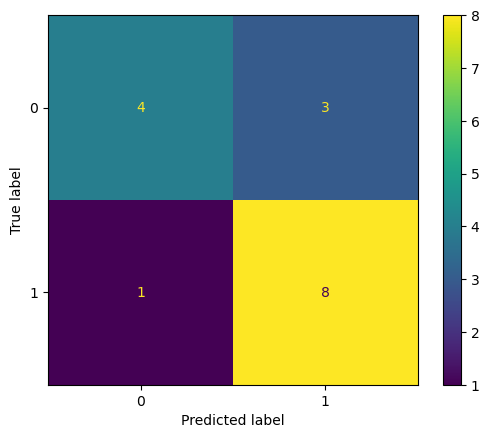

In [36]:
XTrain, XTest, yTrain, yTest = train_test_split(predictors,labels, random_state=3)

model = ensemble.RandomForestClassifier()

model.fit(XTrain,yTrain)

print(model.score(XTrain,yTrain))

print(model.score(XTest,yTest))

yPred = model.predict(XTest)

ConfusionMatrixDisplay(confusion_matrix(yTest, yPred), display_labels=model.classes_).plot()